### Introduction

In this project, our task is to develop an algorithm that detects metastatic cancer in small image patches extracted from larger digital pathology scans. The dataset used is a modified version of the PatchCamelyon (PCam) benchmark dataset. Unlike the original PCam dataset, which includes duplicate images due to probabilistic sampling, the Kaggle version provided here has been adjusted to remove duplicates.



### Dataset
The dataset contains images in TIFF format. The image size is 96x96 pixels in RGB color encoding. The training dataset doesn't contain duplicates. 

There is also *train_lables.csv* which contains a list of filenames without file extensions and the relevant labels for the training dataset. The test dataset doesn't contain the labels. 

In [1]:
import os
import random
import pickle

import numpy as np 
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Training CNN models

In this project, we will compare the performance of the tini-tiny cnn model with the state of and art ResNet50. 

In [2]:
#base_path = '/kaggle/input/histopathologic-cancer-detection/'
base_path = ''
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

Let's take a look at the *train_lables.csv*:

In [3]:
tl_df = pd.read_csv(os.path.join(base_path, 'train_labels.csv'))
tl_df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


As we can see, there are 220,025 images in the training dataset.

In [4]:
tl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


We need to do two things. At first, we need to cast the label to string. It is required for keras.

Another thing is we need to create paths to the the files based on the **id** field in the dataset.

In [5]:
tl_df['label_str'] = tl_df['label'].astype('str')
tl_df['file'] = tl_df.apply(lambda r: os.path.join(train_path, r['id']+'.tif'), axis=1)
tl_df

,id,label,label_str,file
0,f38a6374c348f90b587e046aac6079959adf3835,0,0,train/f38a6374c348f90b587e046aac6079959adf3835...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,1,train/c18f2d887b7ae4f6742ee445113fa1aef383ed77...
2,755db6279dae599ebb4d39a9123cce439965282d,0,0,train/755db6279dae599ebb4d39a9123cce439965282d...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,0,train/bc3f0c64fb968ff4a8bd33af6971ecae77c75e08...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,0,train/068aba587a4950175d04c680d38943fd488d6a9d...
...,...,...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0,0,train/53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6...
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1,1,train/d4b854fe38b07fe2831ad73892b3cec877689576...
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0,0,train/3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75...
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0,0,train/f129691c13433f66e1e0671ff1fe80944816f5a2...


Let's take a look at the images. We will sample 10 of them randomly. 

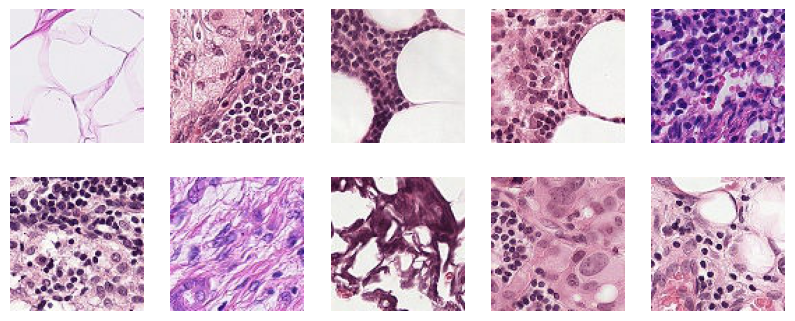

In [6]:
imgs = tl_df.sample(10).apply(lambda r: Image.open(r['file']), axis=1).to_list()
_, axs = plt.subplots(2, 5, figsize=(10, 4))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
    ax.axis('off')
plt.show()

Let's take a look at the distribution of the labels:

In [50]:
tl_df[tl_df['label']==1]['label'].count()/tl_df['label'].count()

0.40503124644926713

Roughly 40% are cancer and 60% are not. So, we can say the dataset is balanced. 

Next, we will split our dataset to train and validate in an 80/20 proportion

In [7]:
train_df, val_df = train_test_split(tl_df, test_size = 0.2, random_state = 1900)

Now we need to prepare the data. For training subset we need the to augment existent images with different permutations of linear operations on them. Like shifting, shearing, rotating etc.

Validation dataset, we need just normalize to $0-1.0$ range. It is $0-255$ now.

In [9]:
image_size = (96, 96)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory = base_path,
    x_col = 'file',
    y_col = 'label_str',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory = base_path,
    x_col = 'file',
    y_col = 'label_str',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


Let's create and train our tiny CNN model. We will use Batch normalization and Dropout, though.

In [27]:
tiny_model = Sequential()
tiny_model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=(96, 96, 3), activation='relu', padding='same'))
tiny_model.add(BatchNormalization())
tiny_model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=(96, 96, 3), activation='relu', padding='same'))
tiny_model.add(BatchNormalization())
tiny_model.add(MaxPool2D(pool_size=(2, 2)))
tiny_model.add(Dropout(0.25))

tiny_model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(96, 96, 3), activation='relu', padding='same'))
tiny_model.add(BatchNormalization())
tiny_model.add(MaxPool2D(pool_size=(2, 2)))

tiny_model.add(Flatten())
tiny_model.add(Dense(32, activation='relu'))
tiny_model.add(Dense(1, activation='sigmoid'))

tiny_model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'AUC'])

tiny_model.summary()

/Users/lbabich/.pyenv/versions/3.10.12/envs/py310-ml/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 96, 96, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 96, 96, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 96, 96, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 597,553 (2.28 MB)

 Trainable params: 597,425 (2.28 MB)

 Non-trainable params: 128 (512.00 B)

In [33]:
if os.path.isfile('./tiny.keras'):
    tiny_model = tf.keras.models.load_model('./tiny.keras')
    with open('tiny_hist.pkl', 'rb') as f:
        tiny_hist = pickle.load(f)
else:    
    tiny_hist = tiny_model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator
    )
    tiny_model.save('./tiny.keras')
    with open('tiny_hist.pkl', 'wb') as f:
        pickle.dump(tiny_hist, f)

In [22]:
train_generator.reset()
val_generator.reset()

Another architecture we will test is ResNet. It is a state-of-the-art model. 

I would expect it to outperform the tiny model described above.

I will use the small version of ResNet, ResNet50.

In [10]:

base_model = ResNet50(weights=None, include_top=False, input_shape=(96, 96, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x) # num_classes is the number of classes in your dataset

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'AUC'])

#model.summary()

2025-02-06 17:38:43.023746: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-02-06 17:38:43.023775: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-02-06 17:38:43.023783: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
I0000 00:00:1738892323.023798 4766682 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1738892323.023818 4766682 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [32]:
if os.path.isfile('./resnet50.keras'):
    model = tf.keras.models.load_model('./resnet50.keras')
    with open('resnet50_hist.pkl', 'rb') as f:
        hist = pickle.load(f)
else:   
    hist = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator
    )
    
    model.save('./resnet50.keras')
    with open('resnet50_hist.pkl', 'wb') as f:
        pickle.dump(hist, f)

In [29]:
def plot_history(history, to_show=['accuracy', 'AUC']):
    _, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    for w, ax in zip(to_show, axs):
        ax.plot(history.history[f'{w}'], label=f'{w}')
        ax.plot(history.history[f'val_{w}'], label=f'val_{w}')
        ax.legend(loc='lower right')
    
    plt.show()



### Evaluation

For evaluation, we will use accuracy and AUC (Area Under the Curve).  

For tiny CNN:

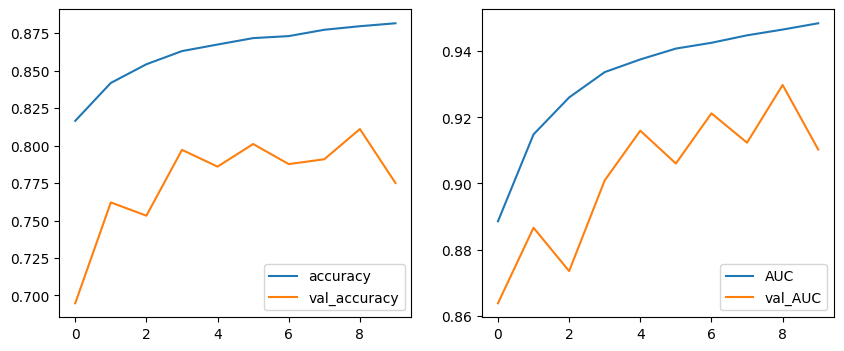

In [34]:
plot_history(tiny_hist)

For ResNet50:

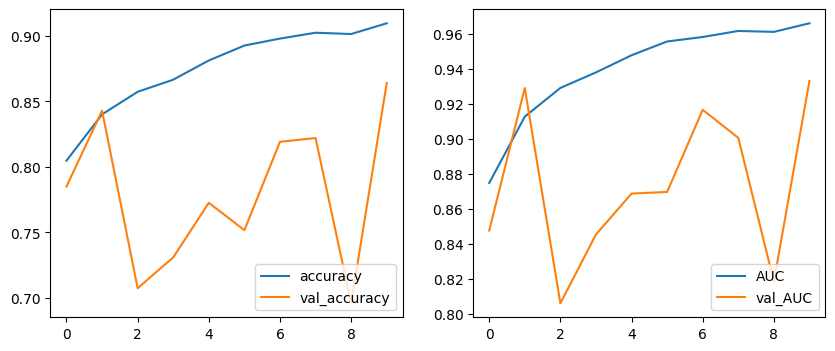

In [35]:
plot_history(hist)

The ResNet50 looks better than the tiny CNN on a training dataset.

But when it comes to validation, it is quite similar. 

However, the last epoch shows that the ResNet50 is slightly better than the tiny CNN. 

### Output
Here, we will prepare a dataset to submit to the Kaggle competition.

In [51]:
test_df = pd.DataFrame({'file': os.listdir(test_path)})
test_df['id'] = test_df.apply(lambda r: r['file'].split('.')[0], axis=1)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_path,
    x_col='file',
    y_col=None,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

pred = model.predict(test_generator)
test_df['label']=(pred>0.5).astype(int)
test_df[['id', 'label']].to_csv('submission.csv')

Found 57458 validated image filenames.


/Users/lbabich/.pyenv/versions/3.10.12/envs/py310-ml/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 66s 37ms/step


### Conclusion



The quite interesting outcome of the project is that even a tiny CNN can have quite a decent performance when predicting cancer. It showed an accuracy of 77% and AUC around 91% on a validation dataset.

Another thing to consider is that the real-world dataset is imbalanced. There are many more negative cases than positive ones. So, we would have to measure the performance of the model on such a dataset.

Another thing to consider is which metric to use. The nature of the problem requires us to detect as many positive cases as possible. So, we need to focus on recall even on the price of precision.
